In [9]:
import lyricsgenius

# create a genius object with your Client API ID
gn = lyricsgenius.Genius("Mtk7ArHzrCFgiewXte-VT1JNfP2YLLj1wtqe-KF-Zd0qiaSeVnCMdzcbER6CCYtO")

In [10]:
# get albums as dictionaries
album_red = gn.search_album("Red","Taylor Swift").to_dict()
album_red_tv = gn.search_album("Red (Taylor’s Version)","Taylor Swift").to_dict()

Searching for "Red" by Taylor Swift...
Searching for "Red (Taylor’s Version)" by Taylor Swift...


In [11]:
# get list of song titles from a dict of the album genius object
    # better to pass in the dict from saved var instead of searching everytime (slow)
def get_titles(album_dict):
    songs_album = []
    for track in album_dict['tracks']:
        songs_album.append(track['song']['title'])
        #print(track['song']['lyrics'])
    return songs_album

# get the titles of all the songs
songs_red_tv = get_titles(album_red_tv)
songs_red = get_titles(album_red)
for i in range(len(s1)):
    # should be the same
    if i < len(s2):
        print(s2[i], "\t",s1[i])
   
    # additional songs
    else:
        print("\t", s1[i])

State of Grace 	 State of Grace (Taylor’s Version)
Red 	 Red (Taylor’s Version)
Treacherous 	 Treacherous (Taylor’s Version)
I Knew You Were Trouble. 	 I Knew You Were Trouble (Taylor’s Version)
All Too Well 	 All Too Well (Taylor’s Version)
22 	 22 (Taylor’s Version)
I Almost Do 	 I Almost Do (Taylor’s Version)
We Are Never Ever Getting Back Together 	 We Are Never Ever Getting Back Together (Taylor’s Version)
Stay Stay Stay 	 Stay Stay Stay (Taylor’s Version)
The Last Time 	 The Last Time (Taylor’s Version)
Holy Ground 	 Holy Ground (Taylor’s Version)
Sad Beautiful Tragic 	 Sad Beautiful Tragic (Taylor’s Version)
The Lucky One 	 The Lucky One (Taylor’s Version)
Everything Has Changed 	 Everything Has Changed (Taylor’s Version)
Starlight 	 Starlight (Taylor’s Version)
Begin Again 	 Begin Again (Taylor’s Version)
The Moment I Knew 	 The Moment I Knew (Taylor’s Version)
Come Back... Be Here 	 Come Back...Be Here (Taylor’s Version)
Girl at Home 	 Girl At Home (Taylor’s Version)
	 State O

In [102]:
import re

# returns a string of the lyrics of song number [song_idx] from album
    # song = string of song name
    # album = dictionary of genius album info, use if have album
    # song_num = number in album, use if have album
        # note: done like this so can get lyrics so singles (not in albums)
        # and its faster to get songs when the album is stored
def get_clean_lyrics(song, album=None, song_num=None):
    
    if album != None and song_num != None:
        lyrics = album['tracks'][song_num]['song']['lyrics']
    else:
        gn_song = gn.search_song(song,"Taylor Swift").to_dict()
        lyrics = gn_song['lyrics']
    
    # remove Verse/Chorus/etc.
    lyrics = re.sub(r'\[.+\]', '', lyrics)
    
    # remove ##EmbedShare URLCopyEmbedCopy that was at the end of each set of lyrics
    lyrics = re.sub(r'[0-9]?[0-9]?EmbedShare URLCopyEmbedCopy','', lyrics)
    
    # remove , () and -
        # unsure if needed but felt like the sentimate wouldnt like:
            # ... you, ... vs ... you ...
            # I-I-I vs I I I 
            # (Mosaic broken hearts) vs Mosaic broken hearts
    lyrics = re.sub(r',', '', lyrics)
    lyrics = re.sub(r'\(|\)', '', lyrics)
    lyrics = re.sub(r'-', ' ', lyrics)
    
    # replace mulitple newlines with 1
    lyrics = re.sub('[\n]+', '\n', lyrics)
    lyrics = lyrics.lower()
    
    return lyrics[1:] # remove the first newline then return the string
    
# ensure both methods yield the same lyrics
assert get_clean_lyrics(songs_red[0]) == (get_clean_lyrics(None,album_red,0))

Searching for "State of Grace" by Taylor Swift...
Done.


In [209]:
# get list of lyrics for all songs
lyrics_red = []
for song in songs_red:
    song_num = songs_red.index(song)
    lyrics_red.append(get_clean_lyrics(None, album_red, song_num))
    
lyrics_red_tv = []
for song in songs_red_tv:
    song_num = songs_red_tv.index(song)
    lyrics_red_tv.append(get_clean_lyrics(None, album_red_tv, song_num))

In [103]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np

# sentiment analysis
analyzer = SentimentIntensityAnalyzer()

# store the sentiments in lists
sentiments_red = [] 
sentiments_red_tv = []

# long string to hold all song lyrics for an album
all_lyrics_red = ""
all_lyrics_red_tv = ""

# compute sentiment analysis
for song in lyrics_red:
    all_lyrics_red += " " + song
    sentiments_red.append(analyzer.polarity_scores(song))

for song in lyrics_red_tv:
    all_lyrics_red_tv += " " + song
    sentiments_red_tv.append(analyzer.polarity_scores(song))

# get overall album sentitment
album_sent_red = analyzer.polarity_scores(all_lyrics_red)
album_sent_red_tv = analyzer.polarity_scores(all_lyrics_red_tv)

In [248]:
import pandas as pd

sent_dict = {}
sent_dict_FtV = {} # store the from the vault values separately

# add the scores from each song
for i in range(len(songs_red_tv)):
    
    # songs in both albums
    if i < len(songs_red):
        sent_dict[songs_red[i]] = [sentiments_red[i]['pos'], sentiments_red[i]['neg'], 
                                   sentiments_red_tv[i]['pos'], sentiments_red_tv[i]['neg']]
    # from the vault on Red TV
    else:
        sent_dict_FtV[songs_red_tv[i]] = [sentiments_red_tv[i]['pos'], sentiments_red_tv[i]['neg']]


# make dataframes with the sentiment dictionaries        
sent_df = pd.DataFrame.from_dict(sent_dict, orient="index", columns=["Red Positive", "Red Negative", 
                                                                     "Red (TV) Positive", "Red (TV) Negative"])
sent_df_FtV = pd.DataFrame.from_dict(sent_dict_FtV, orient="index", columns=["Red (TV) Positive", "Red (TV) Negative"])

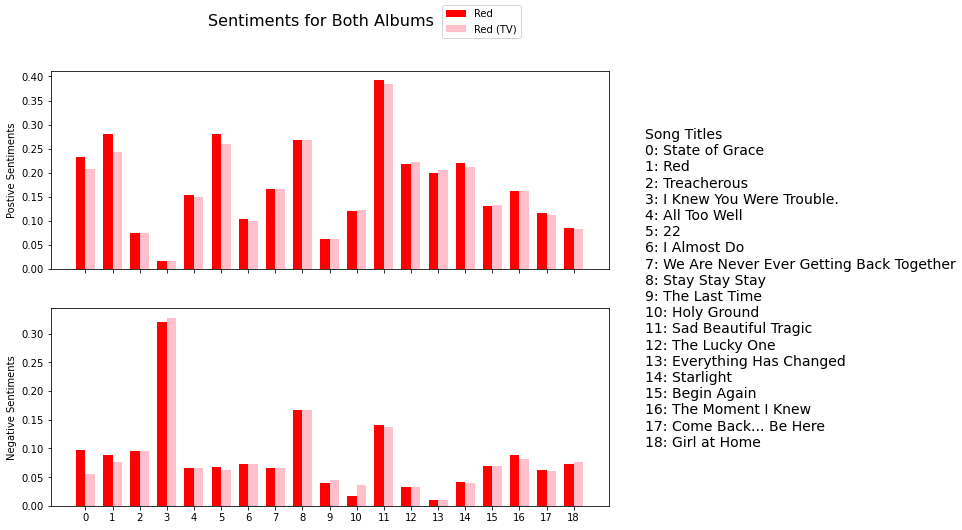

In [299]:
import matplotlib.pyplot as plt
%matplotlib inline

# make a plot of sentiments for songs in both original and Taylor's version of the album
num_bars = np.arange(len(sent_df['Red Positive']))
bar_w = 0.35

# make subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

# make the xticks the song names
    # took the first 20 characters (some of the titles were long)
plt.xticks(num_bars + bar_w/2, [i for i in range(len(sent_df.index))])

# red bars for Red and pinks bars for Red (TV)
ax1.bar(num_bars, sent_df['Red Positive'], color='r', 
           width=bar_w, label='Red')
ax1.bar(num_bars + bar_w, sent_df['Red (TV) Positive'], color='pink', 
           width=bar_w, label='Red (TV)')

# repeat for negative
ax2.bar(num_bars, sent_df['Red Negative'], color='r', 
           width=bar_w)
ax2.bar(num_bars + bar_w, sent_df['Red (TV) Negative'], color='pink', 
           width=bar_w)

fig.legend(loc='upper center')

# make the list of songs
song_title_idx = "Song Titles \n"
for i in range(len(sent_df.index)):
    song_title_idx += str(i) + ": " + sent_df.index[i] + "\n"
plt.figtext(0.95, 0.2, song_title_idx, fontsize=14)
plt.suptitle("Sentiments for Both Albums", fontsize=16)

# set labels for the subplots
plt.setp(ax1, ylabel='Postive Sentiments')
plt.setp(ax2, ylabel='Negative Sentiments')
plt.savefig('RereleasedSongSentiments.png')
plt.show()

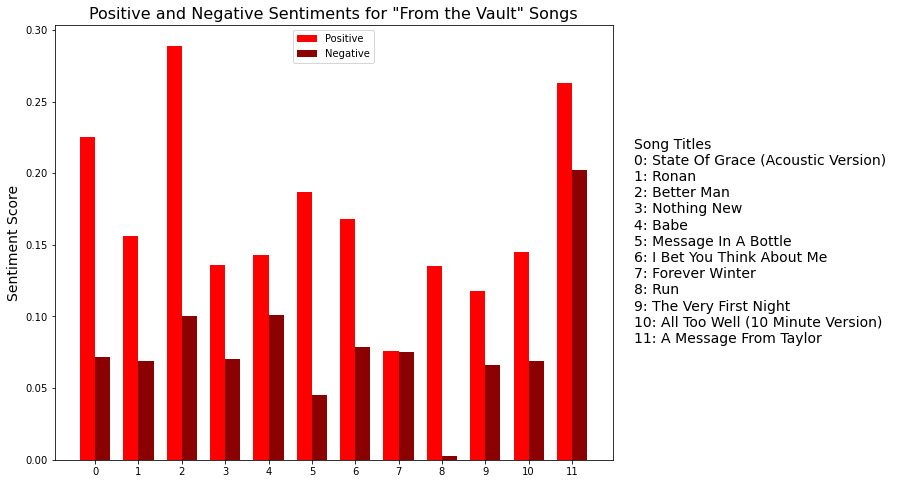

In [301]:
%matplotlib inline

# plot the new songs' sentiments
num_bars = np.arange(len(sent_df_FtV['Red (TV) Positive']))
bar_w = 0.35

plt.figure(figsize=(10, 8))
# make the xticks the songs names
    # took the first 20 characters (some of the titles were long)
plt.xticks(num_bars + bar_w/2, [i for i in range(len(sent_df_FtV.index))])

plt.bar(num_bars, sent_df_FtV['Red (TV) Positive'], color='r', 
           width=bar_w, label='Positive')
plt.bar(num_bars + bar_w, sent_df_FtV['Red (TV) Negative'], color='darkred', 
           width=bar_w, label='Negative')
plt.legend(loc='upper center')

# make the list of songs
song_title_idx = "Song Titles \n"
for i in range(len(sent_df_FtV.index)):
    song = re.sub(r'\[.+\]', '', sent_df_FtV.index[i]) # remove [From the Vault]
    song = re.sub(r'\(T.+\)', '', song) # remove (Taylor's Version)
    song_title_idx += str(i) + ": " + song + "\n"
plt.figtext(0.93, 0.3, song_title_idx, fontsize=14)

plt.title('Positive and Negative Sentiments for "From the Vault" Songs', fontsize=16)
plt.ylabel('Sentiment Score', fontsize=14)
plt.savefig('FtVSongSentiments.png')
plt.show()

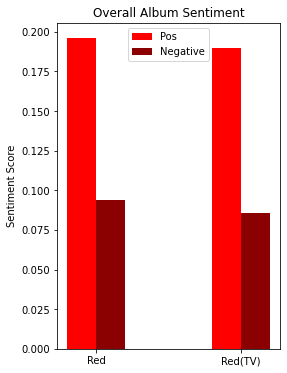

In [302]:
# plot the album overall
%matplotlib inline

num_bars = np.arange(2)
bar_w = 0.2
plt.figure(figsize=(4,6))
plt.xticks(num_bars + bar_w/ 2, ['Red', 'Red(TV)'])
plt.bar(num_bars, [album_sent_red['pos'], album_sent_red_tv['pos']], color='r', 
           width=bar_w, label='Pos')
plt.bar(num_bars + bar_w, [album_sent_red['neg'], album_sent_red_tv['neg']], color='darkred', 
           width=bar_w, label='Negative')
plt.ylabel("Sentiment Score")
plt.legend(loc='upper center')
plt.title("Overall Album Sentiment")
plt.savefig('OverallSentiments.png')
plt.show()

In [218]:
# compare all too wells
# she released All Too Well (Sad Girl Autumn Version) - does sad mean more negative?
    # it shouldnt, the lyrics seem the same, but the pacing is different
lyrics_gsav = get_clean_lyrics("All Too Well (Sad Girl Autumn Version)")
sent_sgav = analyzer.polarity_scores(lyrics_gsav)

Searching for "All Too Well (Sad Girl Autumn Version)" by Taylor Swift...
Done.


In [291]:
# make a dataframe with all of the data from each of the versions
print("All Too Well Variation Sentiments")
all_too_well = dict()
all_too_well['Original'] = [sent_df.loc["All Too Well", "Red Positive"], sent_df.loc["All Too Well", "Red Negative"]]
all_too_well['Taylor\'s Version'] = [sent_df.loc["All Too Well", "Red (TV) Positive"], 
                                      sent_df.loc["All Too Well", "Red (TV) Negative"]]
all_too_well['10 Minute'] = [sent_df_FtV.loc["All Too Well (10 Minute Version) (Taylor’s Version) [From the Vault]", "Red (TV) Positive"], 
                              sent_df_FtV.loc["All Too Well (10 Minute Version) (Taylor’s Version) [From the Vault]", "Red (TV) Negative"]]
all_too_well['Sad Girl Autumn'] = [sent_sgav['pos'], sent_sgav['neg']]
all_too_well_df = pd.DataFrame.from_dict(all_too_well, orient="index", columns=["Positive", "Negative"])
all_too_well_df 

All Too Well Variation Sentiments


,Positive,Negative
Original,0.153,0.066
Taylor's Version,0.149,0.066
10 Minute,0.145,0.069
Sad Girl Autumn,0.143,0.071


In [236]:
# idf-tf
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

# adapted from Week 7: Bag of Words Matrix
# Get list of stopwords and add a few
stop_words = set(stopwords.words('english'))
def get_clean_words(text):

    # replace wanna and gonna before tokenize
        # split into wan, na and gon, na 
        # made na seems like a very important word
    text = re.sub('gonna', 'going to', text)
    text = re.sub('wanna', 'want to', text)
    
    # extract words
    words = word_tokenize(text)
    
    # Convert to lower case
    words = [w.lower() for w in words]
    
    # Remove non-alphabetic words
    words = [w for w in words if w.isalpha()]
    # Remove stop words
    words = [w for w in words if not w in stop_words]
    
    # Remove single letter words 
    words = [w for w in words if len(w) > 1]

    return words

# make 2 matrices for each album
words_red = sorted(list(set(get_clean_words(all_lyrics_red))))
words_red_tv = sorted(list(set(get_clean_words(all_lyrics_red_tv))))

# red
red_mat = dict()
for song, lyrics in zip(songs_red, lyrics_red):
    
    # initialize to list of zeroes
    vec = np.zeros(len(words_red))
    
    # for all words in the lyrics, increment the corresponding column
    for word in get_clean_words(lyrics):
        idx = words_red.index(word)
        vec[idx] += 1
       
    # assign to the song
    red_mat[song] = vec

red_mat = pd.DataFrame.from_dict(red_mat, orient="index", columns=words_red)
red_mat

def make_bag_of_words(all_words, songs, lyrics):
    # red
    bag_of_words = dict()
    for song, lyric in zip(songs, lyrics):

        # initialize to list of zeroes
        vec = np.zeros(len(all_words))

        # for all words in the lyrics, increment the corresponding column
        for word in get_clean_words(lyric):
            idx = all_words.index(word)
            vec[idx] += 1

        # assign to the song
        bag_of_words[song] = vec

    bag_of_words = pd.DataFrame.from_dict(bag_of_words, orient="index", columns=all_words)
    return bag_of_words
bow_red = make_bag_of_words(words_red, songs_red, lyrics_red)
bow_red_tv = make_bag_of_words(words_red_tv, songs_red_tv, lyrics_red_tv)

In [237]:
#'everybody' shows up twice (at the end of a sorted list??), but only the first one is filled with data
bow_red_tv = bow_red_tv.iloc[: , :-1]

In [238]:
# must have some strange characters in it? - is the only one that shows up at the end, so probably the only instance
    # just a check on the value of the letters
print("the first two letters are not equal:",words_red_tv[-1][0], words_red_tv[271][0], words_red_tv[-1][0]==words_red_tv[271][0])
print("unicode for", words_red_tv[-1][0], ord(words_red_tv[-1][0]))
print("unicode for", words_red_tv[271][0], ord(words_red_tv[271][0]))

the first two letters are not equal: е e False
unicode for е 1077
unicode for e 101


In [233]:
from sklearn.feature_extraction.text import TfidfTransformer
import scipy.sparse as sc

# take a bag of words dictionary and use the tf-idf transformation
    # returns a data frame of the transformed bow
def get_tfidf(bow):
    tfidf_transformer=TfidfTransformer()
    tfidf = tfidf_transformer.fit_transform(bow) # do the transform
    bow_tfidf = pd.DataFrame.sparse.from_spmatrix(tfidf, index=bow.index, columns=bow.columns) # convert to dataframe
    return bow_tfidf

bow_red_tfidf = get_tfidf(bow_red)
bow_red_tv_tfidf = get_tfidf(bow_red_tv)

In [234]:
# take a bag of words matrix that has been tf-idf transformed
    # return a dictionary
        # key: word
        # value: sum of document importances for all documents (songs)
def get_importances(bow_tfidf):
    word_importance = dict()
    for word in bow_tfidf.columns:
        word_importance[word] = bow_tfidf[word].sum()
    return word_importance

word_imp_red = get_importances(bow_red_tfidf)
word_imp_red_tv = get_importances(bow_red_tv_tfidf)

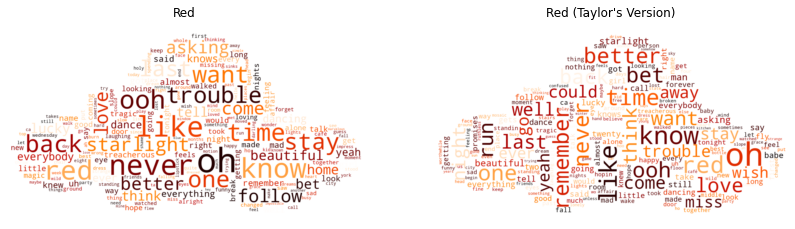

In [247]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud 
from PIL import Image

# make the word cloud cloud-shaped
shape = np.array(Image.open('cloud.png'))

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(14, 12))

# use a red color scheme to match RED album theme
# use the importances calculated from the tf-idf as frequency 
    # word size corresponds to word importance in the album
wc_red = WordCloud(colormap='gist_heat', background_color='white', mask=shape).generate_from_frequencies(word_imp_red)
ax1.set_title("Red")
ax1.imshow(wc_red, interpolation="bilinear")
ax1.axis('off')

wc_red_tv = WordCloud(colormap='gist_heat', background_color='white', mask=shape).generate_from_frequencies(word_imp_red_tv)
ax2.set_title("Red (Taylor's Version)")
ax2.imshow(wc_red_tv, interpolation="bilinear")
ax2.axis('off')
plt.savefig('wordcloud.png')
plt.show()